In [17]:
import numpy as np
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt
from scipy.signal import firwin

class _UpFIRDn(object):
    def __init__(self, h, x_dtype, up, down):
        """Helper for resampling"""
        h = np.asarray(h)
        if h.ndim != 1 or h.size == 0:
            raise ValueError('h must be 1D with non-zero length')
        self._output_type = np.result_type(h.dtype, x_dtype, np.float32)
        h = np.asarray(h, self._output_type)
        self._up = int(up)
        self._down = int(down)
        if self._up < 1 or self._down < 1:
            raise ValueError('Both up and down must be >= 1')
        # This both transposes, and "flips" each phase for filtering
        self._h_trans_flip = _pad_h(h, self._up)

    def apply_filter(self, x):
        """Apply the prepared filter to a 1D signal x"""
        output_len = _output_len(len(self._h_trans_flip), len(x),
                                 self._up, self._down)
        out = np.zeros(output_len, dtype=self._output_type)
        _apply(np.asarray(x, self._output_type), self._h_trans_flip, out,
               self._up, self._down)
        return out

def _pad_h(h, up):
    """Store coefficients in a transposed, flipped arrangement.
    For example, suppose upRate is 3, and the
    input number of coefficients is 10, represented as h[0], ..., h[9].
    Then the internal buffer will look like this::
       h[9], h[6], h[3], h[0],   // flipped phase 0 coefs
       0,    h[7], h[4], h[1],   // flipped phase 1 coefs (zero-padded)
       0,    h[8], h[5], h[2],   // flipped phase 2 coefs (zero-padded)
    """
    h_padlen = len(h) + (-len(h) % up)
    h_full = np.zeros(h_padlen, h.dtype)
    h_full[:len(h)] = h
    h_full = h_full.reshape(-1, up).T[:, ::-1].ravel()
    return h_full

In [10]:
up=1
down=2
window=('kaiser', 5.0)

fs = 256
axis = 0
s = np.linspace(0,10,fs*1)
x = np.sin(2*np.pi*1*s, dtype=np.float32) + np.sin(2*np.pi*6*s, dtype=np.float32) \
    + np.sin(2*np.pi*4*s, dtype=np.float32) + np.sin(2*np.pi*8*s, dtype=np.float32)  

In [11]:
n_out = x.shape[0]/2

In [12]:
max_rate = max(up, down)
f_c = 1. / max_rate  # cutoff of FIR filter (rel. to Nyquist)
half_len = 10 * max_rate  # reasonable cutoff for our sinc-like function
h = firwin(2 * half_len + 1, f_c, window=window)
h *= up

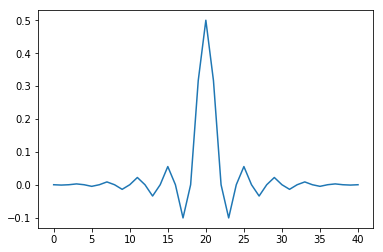

In [13]:
plt.plot(h)

In [14]:
# Zero-pad our filter to put the output samples at the center
n_pre_pad = (down - half_len % down)
n_post_pad = 0
n_pre_remove = (half_len + n_pre_pad) // down
h = np.concatenate((np.zeros(n_pre_pad), h, np.zeros(n_post_pad)))

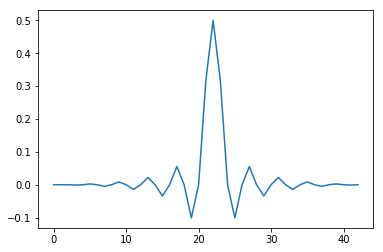

In [15]:
plt.plot(h)

In [18]:
ufd = _UpFIRDn(h, x.dtype, up, down)

In [19]:
ufd